In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 334 (delta 116), reused 113 (delta 86), pack-reused 162 (from 1)
Receiving objects: 100% (334/334), 236.58 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 41.0 MB/s eta 0:00:00


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 75.7MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

<ipython-input-5-3749d135369e>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [16]:
prediction_length=7 # our data is daily, so we'll predict one week out
context_length = prediction_length*4
num_samples = 20
device = "cpu"
batch_size = 64

ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

zs_estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device=torch.device('cpu'),

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=True,

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

<ipython-input-16-2e166f00f992>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)
/usr/local/lib/python3.10/dist-pack

In [9]:
from gluonts.dataset.pandas import PandasDataset

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index("Date")
df = df.resample('D').sum().interpolate('linear')

In [12]:
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

train_end = round(len(df) * 0.7)
valid_end = round(len(df) * 0.9)
train = PandasDataset(df[:train_end], freq="1d", target="Temp")
valid = PandasDataset(df[train_end:valid_end], freq="1d", target="Temp")
test = PandasDataset(df[valid_end:], freq="1d", target="Temp")

In [139]:
train

PandasDataset<size=1, freq=1d, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [17]:
date_list = pd.date_range(df[valid_end:].index[60], periods=9, freq="30d").tolist()
date_list

zs_forecasts = []
zs_tss = []

for d in date_list:
  print(d)
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(df[:d], freq="1d", target="Temp"),
          predictor=zs_predictor,
          num_samples=num_samples
      )
  zs_forecasts.append(list(forecast_it))
  zs_tss.append(list(ts_it))

1990-03-02 00:00:00
1990-04-01 00:00:00
1990-05-01 00:00:00
1990-05-31 00:00:00
1990-06-30 00:00:00
1990-07-30 00:00:00
1990-08-29 00:00:00
1990-09-28 00:00:00
1990-10-28 00:00:00


In [18]:
evaluator = Evaluator()
zs_a_metrics = []
zs_t_metrics = []

for (t,s) in zip(zs_tss, zs_forecasts):
  agg_metrics, ts_metrics = evaluator(t, s)
  zs_a_metrics.append(agg_metrics)
  zs_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 33.18it/s]
Running evaluation: 1it [00:00, 36.31it/s]
Running evaluation: 1it [00:00, 41.67it/s]
Running evaluation: 1it [00:00, 42.58it/s]
Running evaluation: 1it [00:00, 35.39it/s]
Running evaluation: 1it [00:00, 56.50it/s]
Running evaluation: 1it [00:00, 36.79it/s]
Running evaluation: 1it [00:00, 36.24it/s]
Running evaluation: 1it [00:00, 38.11it/s]


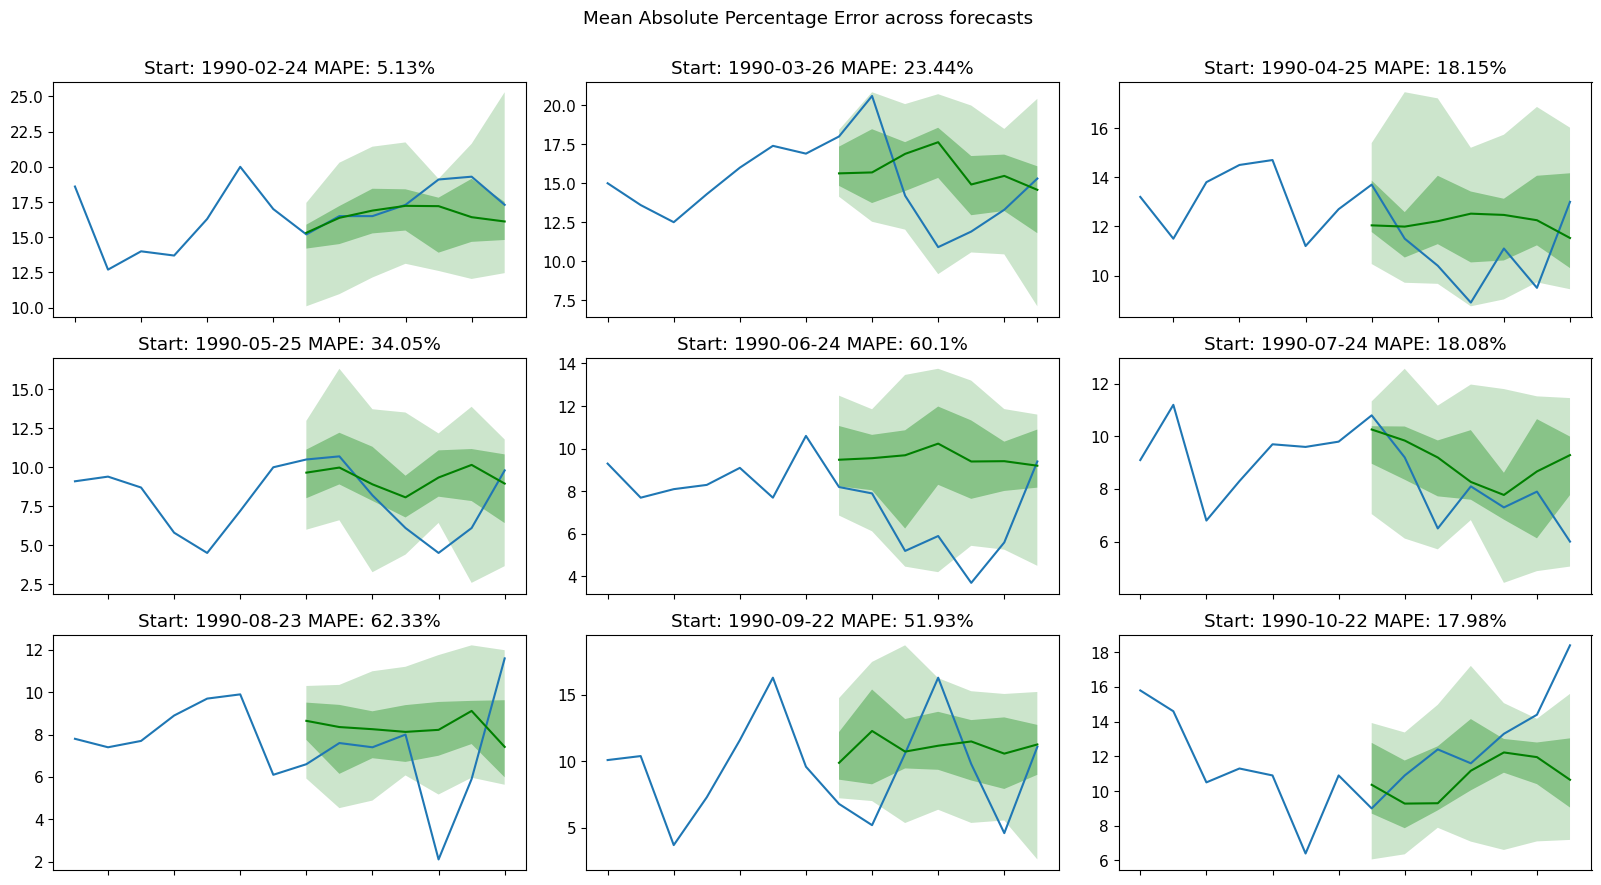

In [19]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

for idx in range(len(zs_forecasts)):
  ax = plt.subplot(3, 3, idx+1)
  t = zs_tss[idx][0][zs_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

  smape = float(f'{zs_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
  smape = float(f'{smape:.2f}')
  ax.set_title("Start: " + str(zs_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
  plt.plot(t.index.to_timestamp(), t[0])
  ax.set_xticklabels([])

  zs_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()

## Fine-tuning

In [26]:
ckpt = torch.load("lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,
        device=torch.device('cpu'),

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,} # lightning trainer arguments
    )

<ipython-input-26-50f4c345b5b5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("lag-llama.ckpt", map_location=device)


In [27]:
finetuned_predictor = estimator.train(train, valid, cache_data=True, shuffle_buffer_length=1000)

/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
INFO: GPU available: True (cuda), used: True
INFO:lightning.p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'val_loss' reached 2.20727 (best 2.20727), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'val_loss' reached 2.20727 (best 2.20727), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 150: 'val_loss' reached 2.19838 (best 2.19838), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: 'val_loss' reached 2.19838 (best 2.19838), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 550: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 750: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 900: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 950: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 1000: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 1050: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 1050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 1100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 1150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 1150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 1200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 1250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 1250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 1300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 1300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 1350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 1350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 1400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 28, global step 1450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 1450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 1500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 30, global step 1550: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 1550: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 31, global step 1600: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 1600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 32, global step 1650: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 1650: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 33, global step 1700: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 34, global step 1750: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 1750: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 35, global step 1800: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 1800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 36, global step 1850: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 1850: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 37, global step 1900: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 38, global step 1950: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 1950: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 39, global step 2000: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 40, global step 2050: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 2050: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 41, global step 2100: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 2100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 42, global step 2150: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 2150: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 43, global step 2200: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 44, global step 2250: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 2250: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 45, global step 2300: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 2300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 46, global step 2350: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 2350: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 47, global step 2400: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 48, global step 2450: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 2450: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 2500: 'val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.10/dist-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

In [145]:
# from google.colab import drive
# drive.mount('/content/drive')

In [146]:
# torch.save(finetuned_predictor, "/content/drive/My Drive/lag-llama/8_29")

In [147]:
# finetuned_predictor = torch.load("/content/drive/My Drive/lag-llama/8_29")

In [22]:
date_list = pd.date_range(df[valid_end:].index[60], periods=9, freq="30d").tolist()

finetune_forecasts = []
finetune_tss = []

for d in date_list:
  print(d)
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(df[:d], freq="1d", target="Temp"),
          predictor=finetuned_predictor,
          num_samples=num_samples
      )
  finetune_forecasts.append(list(forecast_it))
  finetune_tss.append(list(ts_it))

1990-03-02 00:00:00
1990-04-01 00:00:00
1990-05-01 00:00:00
1990-05-31 00:00:00
1990-06-30 00:00:00
1990-07-30 00:00:00
1990-08-29 00:00:00
1990-09-28 00:00:00
1990-10-28 00:00:00


In [23]:
#evaluator = Evaluator()
finetune_a_metrics = []
finetune_t_metrics = []

for (t,s) in zip(finetune_tss, finetune_forecasts):
  agg_metrics, ts_metrics = evaluator(t, s)
  finetune_a_metrics.append(agg_metrics)
  finetune_t_metrics.append(ts_metrics)

Running evaluation: 1it [00:00, 24.20it/s]
Running evaluation: 1it [00:00, 39.83it/s]
Running evaluation: 1it [00:00, 57.90it/s]
Running evaluation: 1it [00:00, 41.16it/s]
Running evaluation: 1it [00:00, 45.47it/s]
Running evaluation: 1it [00:00, 45.73it/s]
Running evaluation: 1it [00:00, 41.16it/s]
Running evaluation: 1it [00:00, 45.23it/s]
Running evaluation: 1it [00:00, 48.82it/s]


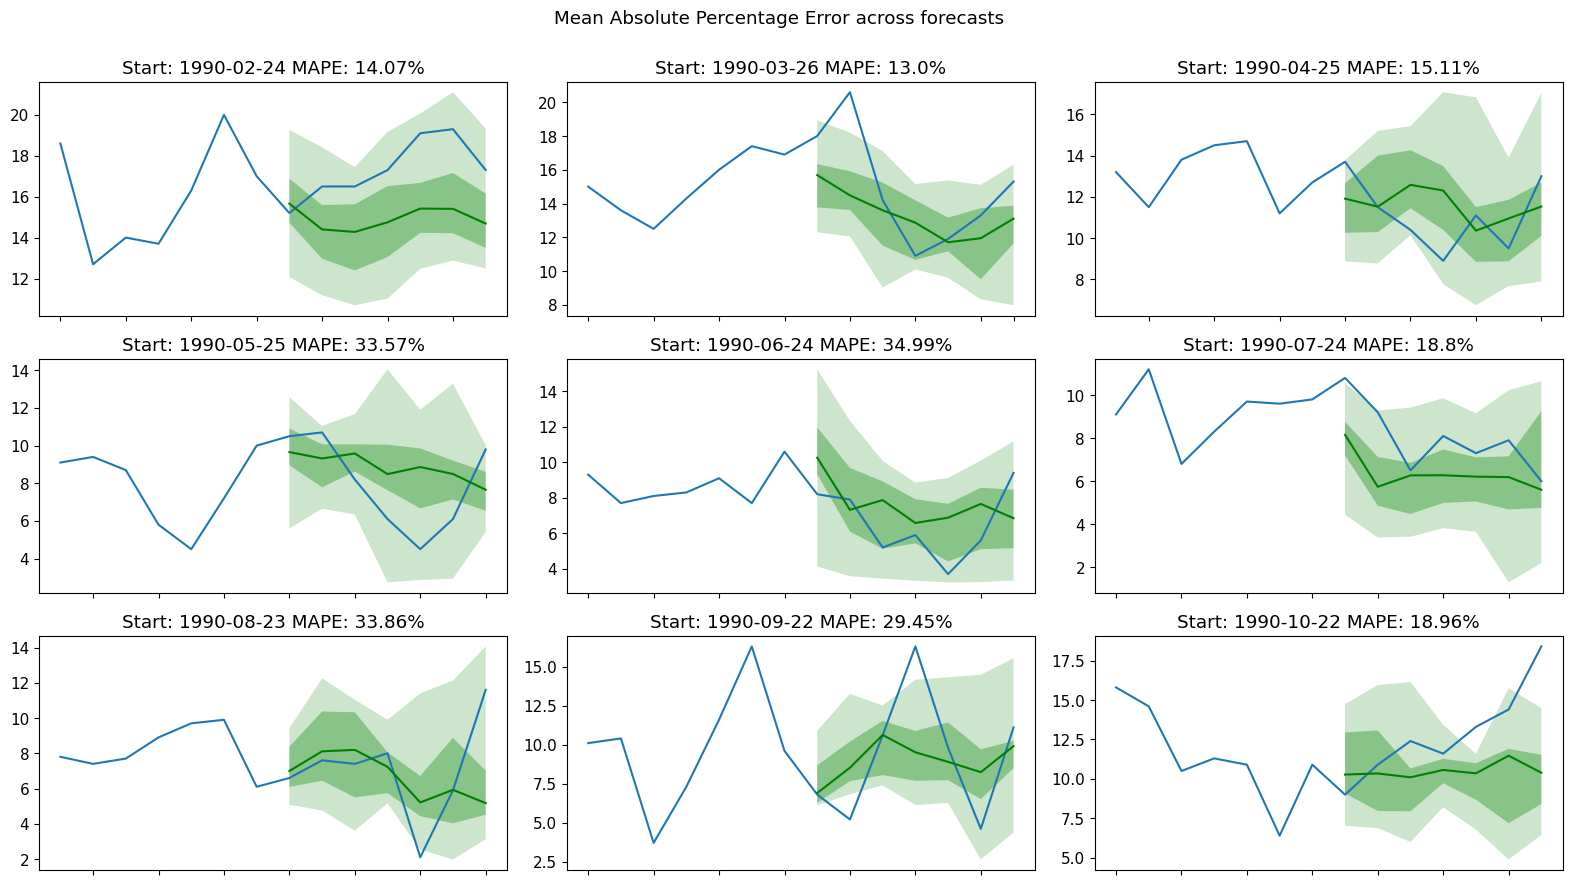

In [24]:
plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 11})

for idx in range(len(finetune_forecasts)):
  ax = plt.subplot(3, 3, idx+1)
  t = finetune_tss[idx][0][finetune_forecasts[idx][0].start_date.to_timestamp() - pd.Timedelta(days=7):]

  smape = float(f'{finetune_t_metrics[idx]["MAPE"][0]:.4f}') * 100.0
  smape = float(f'{smape:.2f}')
  ax.set_title("Start: " + str(finetune_t_metrics[idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
  plt.plot(t.index.to_timestamp(), t[0])
  ax.set_xticklabels([])

  finetune_forecasts[idx][0].plot(color='g')

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.show()

In [39]:
zs_t_metrics[0]

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,None,1990-02-24,2.540119,6.650304,121.199997,17.314285,2.155958,0.440659,0.051321,0.054078,...,6.650304,0.285714,8.714506,0.428571,9.010351,0.571429,5.047384,0.857143,4.253507,0.857143


In [48]:
from IPython.display import HTML, display
comparison = pd.DataFrame()

for (z, f) in zip(zs_t_metrics, finetune_t_metrics):
  comparison = pd.concat([comparison, pd.DataFrame({"Date":f['forecast_start'], "Finetuned MAPE":f['MAPE'][0] * 100, "Zeroshot MAPE":z['MAPE'][0] * 100, "Finetuning Improvement":(z['MAPE'][0] - f['MAPE'][0]) * 100})])


display(HTML(comparison.to_html()))

,Date,Finetuned MAPE,Zeroshot MAPE,Finetuning Improvement
0,1990-02-24,14.074690,5.132133,-8.942557
0,1990-03-26,12.999803,23.437066,10.437263
0,1990-04-25,15.111790,18.150030,3.038239
0,1990-05-25,33.572088,34.048983,0.476895
0,1990-06-24,34.988431,60.099336,25.110906
0,1990-07-24,18.796240,18.077844,-0.718396
0,1990-08-23,33.861474,62.327957,28.466484
0,1990-09-22,29.453261,51.933639,22.480379
0,1990-10-22,18.961399,17.984154,-0.977245
